In [60]:

import pandas as pd
import numpy as np
import tensorflow as tf
import larq as lq
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']


data.dropna(subset=['message', 'label'], inplace=True)


data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# T and P
max_features = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['message'])
sequences = tokenizer.texts_to_sequences(data['message'])
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(data['label'])


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=32, input_length=max_len),
    tf.keras.layers.Flatten(),  # to flatten output
    lq.layers.QuantDense(1, use_bias=False, activation='sigmoid', kernel_quantizer="ste_sign", kernel_constraint="weight_clip"),
])


# Compiling
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])


model.summary()

# training
num_epochs = 10
batch_size = 32

history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test)
)





Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 32)           320000    
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 quant_dense_11 (QuantDense  (None, 1)                 3200      
 )                                                               
                                                                 
Total params: 323200 (1.23 MB)
Trainable params: 323200 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
140/140 [==============================] - 2s 8ms/step - loss: 0.1903 - accuracy: 0.9280 - val_loss: 0.0865 - val_accuracy: 0.9758
Epoch 2/10
140/140 [==============================] - 1s 11ms/step - loss:

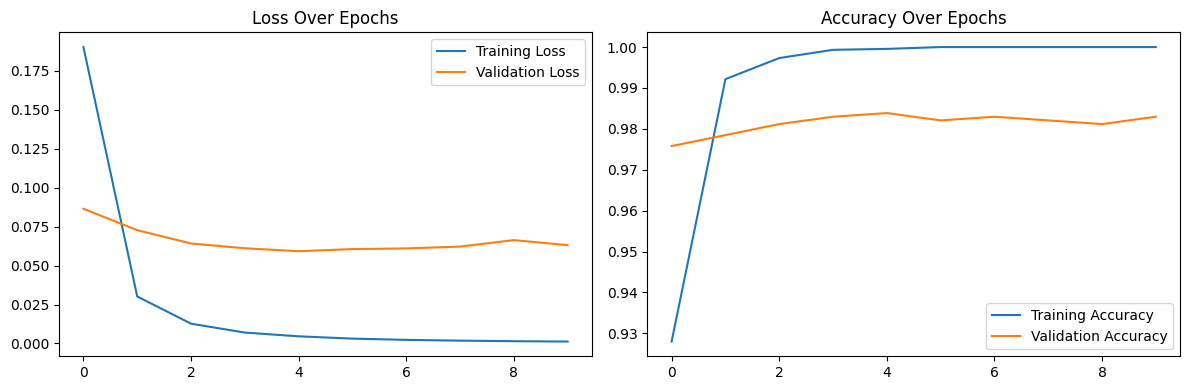

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()
